In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
from plot_utils import cool_savefig

In [3]:
small_batches_compositions = np.zeros((1500*500))
medium_batches_compositions = np.zeros((30*500))
large_batches_compositions = np.zeros((500))

In [4]:
from glob import glob

filenames = sorted(list(glob('concentration_ML_estimates/*.compositional.npz')))
len(filenames)

500

In [5]:
for sim_num in range(500):
    npzfile = np.load(filenames[sim_num])
    
    small_batches_compositions[sim_num*1500:(sim_num+1)*1500] = npzfile['small_batches']
    medium_batches_compositions[sim_num*30:(sim_num+1)*30] = npzfile['medium_batches']
    large_batches_compositions[sim_num] = npzfile['whole_sim']

In [6]:
print(np.mean(small_batches_compositions < np.inf))
print(np.mean(medium_batches_compositions < np.inf))
print(np.mean(large_batches_compositions < np.inf))

0.5510706666666667
0.6128666666666667
0.68


given the bimodal distribution of large and "super large" estimates, firsthand investigation of some of the super large estimates which were really `fsolve` failing to do its job, and the fact that we know in many cases there should be no maximum, and any "root" is really just part of an asymptotic approach towards $0$, I'll filter anything greater than $10^7$ as infinite.

In [7]:
small_batches_compositions[small_batches_compositions > 10**7] = np.inf
medium_batches_compositions[medium_batches_compositions > 10**7] = np.inf
large_batches_compositions[large_batches_compositions > 10**7] = np.inf

In [8]:
print(np.mean(small_batches_compositions < np.inf))
print(np.mean(medium_batches_compositions < np.inf))
print(np.mean(large_batches_compositions < np.inf))

0.45439066666666666
0.5155333333333333
0.556


a priori we know that estimates less than $0$ (which then were "manually" changed to $0$) are junk caused by `fsolve` being dumb -- so let's try to gauge what percentage of the data is affected by this problem

In [9]:
print(np.mean(small_batches_compositions > 0))
print(np.mean(medium_batches_compositions > 0))
print(np.mean(large_batches_compositions > 0))

0.9999773333333334
0.9693333333333334
0.934


kind of frustrating that this number is so large for the large batches, but admittedly more or less matches the firsthand experience I had. anyway after a certain point I doubt that there's much if anything that could be done about it. I guess I could replace the $0$'s with $\infty$'s, since that seemed to be what the issue was in practice (i.e. the score function undefined at $0$, but seems to approach zero asymptotically for $\pm \infty$ in some cases, so when `fsolve` messed up and started chasing the $-\infty$ asymptote, I replaced the large negative value with $0$)

In [10]:
small_batches_compositions = small_batches_compositions[small_batches_compositions > 0]
medium_batches_compositions = medium_batches_compositions[medium_batches_compositions > 0]
large_batches_compositions = large_batches_compositions[large_batches_compositions > 0]

In [11]:
def small_part(array, x): return array[array < x]
def finite_part(array): return small_part(array, np.inf)

In [12]:
def x_fmt(x, pos):
    return '$10^{{{}}}$'.format(x).replace('.0','').replace('.5', '')

In [13]:
from statsmodels.distributions.empirical_distribution import ECDF

In [14]:
def crest(index):
    return sns.color_palette("crest")[index]

def magma(index):
    return sns.color_palette("magma")[index]

# Compositional Heterogeneity

In [15]:
small_ecdf_comp = ECDF(small_batches_compositions)
medium_ecdf_comp = ECDF(medium_batches_compositions)
large_ecdf_comp = ECDF(large_batches_compositions)

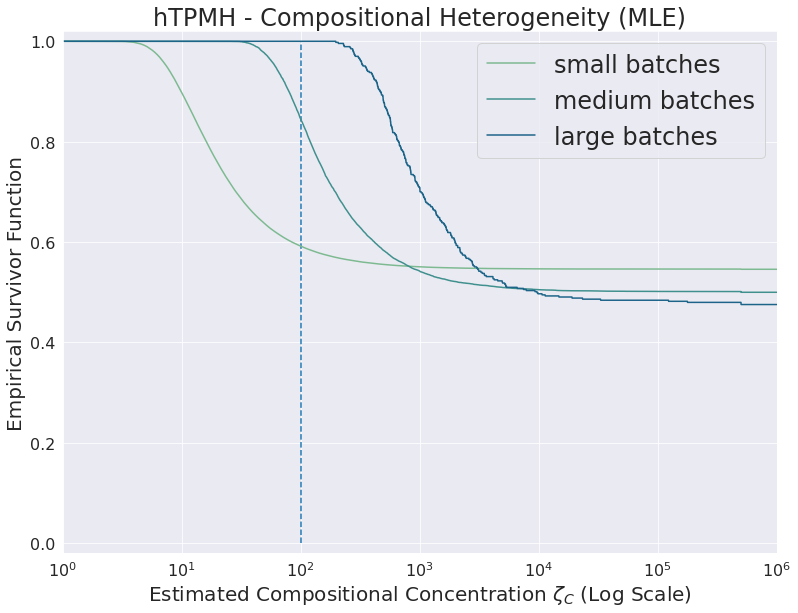

In [16]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12.8,9.6))
    xvals = np.logspace(start=0, stop=6, num=10000)
    axis = sns.lineplot(x=np.log(xvals)/np.log(10), y=1.-small_ecdf_comp(xvals), color=crest(0))
    sns.lineplot(x=np.log(xvals)/np.log(10), y=1.-medium_ecdf_comp(xvals), color=crest(2))
    sns.lineplot(x=np.log(xvals)/np.log(10), y=1. - large_ecdf_comp(xvals), color=crest(4))
    axis.legend(labels=["small batches", "medium batches", "large batches"], fontsize=24)
    axis.set_ylabel('Empirical Survivor Function', fontsize=20)
    axis.set_ylim((-0.02,1.02))
    plt.stem([2], [1.-large_ecdf_comp(100)], markerfmt='', linefmt='C0--')
    axis.set_xlim((0,6))
    axis.set_xlabel('Estimated Compositional Concentration $\zeta_C$ (Log Scale)', fontsize=20)
    axis.xaxis.set_major_formatter(mtick.FuncFormatter(x_fmt))
    axis.tick_params(labelsize=16)
    title = 'hTPMH - Compositional Heterogeneity (MLE)'
    plt.title(title, fontsize=24)
    cool_savefig(title + ' survival')

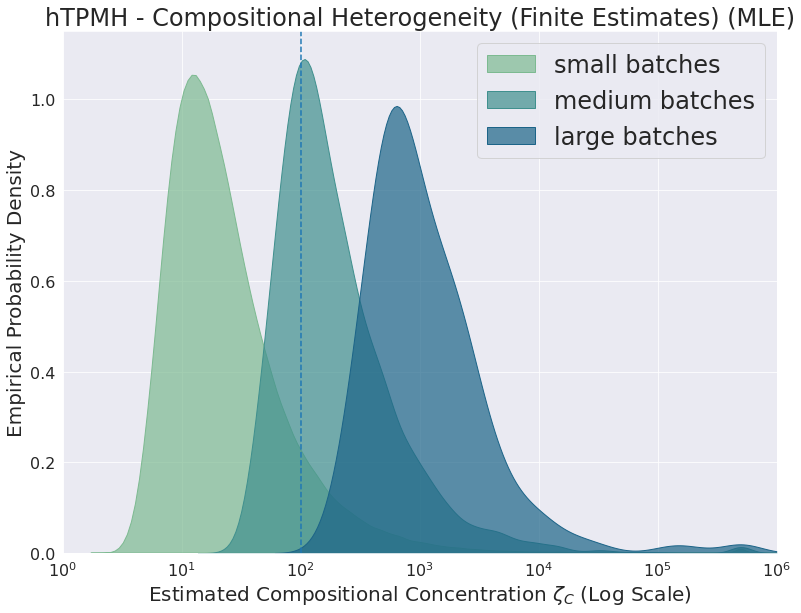

In [17]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12.8, 9.6))
    axis = sns.kdeplot(np.log(finite_part(small_batches_compositions))/np.log(10), color=crest(0), fill=True, alpha=0.7)
    sns.kdeplot(np.log(finite_part(medium_batches_compositions))/np.log(10), ax=axis, color=crest(2), fill=True, alpha=0.7)
    sns.kdeplot(np.log(finite_part(large_batches_compositions))/np.log(10), ax=axis, color=crest(4), fill=True, alpha=0.7)
    axis.legend(labels=["small batches", "medium batches", "large batches"], fontsize=24)
    axis.xaxis.set_major_formatter(mtick.FuncFormatter(x_fmt))
    axis.set_ylabel('Empirical Probability Density', fontsize=20)
    axis.set_xlabel('Estimated Compositional Concentration $\zeta_C$ (Log Scale)', fontsize=20)
    axis.tick_params(labelsize=16)
    plt.stem([2], [1.2], markerfmt='', linefmt='C0--')
    axis.set_ylim((0,1.15))
    axis.set_xlim((0,6))
    title = 'hTPMH - Compositional Heterogeneity (Finite Estimates) (MLE)'
    plt.title(title, fontsize=24)
    cool_savefig(title + ' kde')

OK given that the true value is $\infty$ in this case, it is a good sign that about $50\%$ of estimates are infinite for the largest batches (since that's what you would expect for random fluctuations of its reciprocal around $0$), and also that the median of the finite estimates clearly shifts rightward with larger batch size